In [1]:
!wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" -O cert.crt -q

In [2]:
import os
import pymongo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


try:
    import dotenv
    dotenv.load_dotenv()
except ImportError:
    pass

client = pymongo.MongoClient(
    host=os.environ['host'],
    port=27018,
    replicaSet='rs01',
    username=os.environ['username'],
    password=os.environ['password'],
    authSource=os.environ['database'],
    tls=True,
    tlsCAFile='cert.crt'
)
db = client[os.environ['database']]

In [3]:
id = 516
run = db.runs.find_one({'_id': id})
run

{'_id': 516,
 'experiment': {'name': 'sensor_test',
  'base_dir': '/home/amir/rqc_internship/UR5-Control',
  'sources': [['grid_toucher.py', ObjectId('6328ac932ef855ba118e0ceb')]],
  'dependencies': ['numpy==1.23.2',
   'pymongo==4.2.0',
   'python-dotenv==0.21.0',
   'PyYAML==6.0',
   'sacred==0.8.2'],
  'repositories': [{'url': 'git@github.com:Hacker1337/UR5-Control.git',
    'commit': 'deb47aba9f606593208987c96a61b00420d500df',
    'dirty': True}],
  'mainfile': 'grid_toucher.py'},
 'format': 'MongoObserver-0.7.0',
 'command': 'touch_sensor',
 'host': {'hostname': 'amir-Lenovo',
  'os': ['Linux', 'Linux-5.15.0-46-generic-x86_64-with-glibc2.31'],
  'python_version': '3.10.6',
  'cpu': 'Intel(R) Core(TM) i7-4500U CPU @ 1.80GHz',
  'ENV': {}},
 'start_time': datetime.datetime(2022, 9, 19, 17, 53, 22, 893000),
 'config': {'ip': '10.201.2.179',
  'left_upper_corner': [0.4498, 0.141],
  'right_down_corner': [0.4366, 0.1111],
  'safe_hight': 0.2843,
  'sensor_hight': 0.2838,
  'max_sensor_

In [3]:
[ x['name'] for x in list(db.metrics.find({'run_id': id}))]

['force_z', 'power', 'point_results']

In [4]:
points_curves = db.metrics.find_one({'_id': db.metrics.find_one({'run_id': id, 'name': 'point_results'})['_id']})['values']
point_res = points_curves[10]

In [6]:
point_res.keys()

dict_keys(['target_coordinate', 'base_coordinate', 'force_z', 'vector_force', 'deformation', 'power', 'aim_force', 'tenso_signal', 'final_power'])

### Force analyse

In [8]:

def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

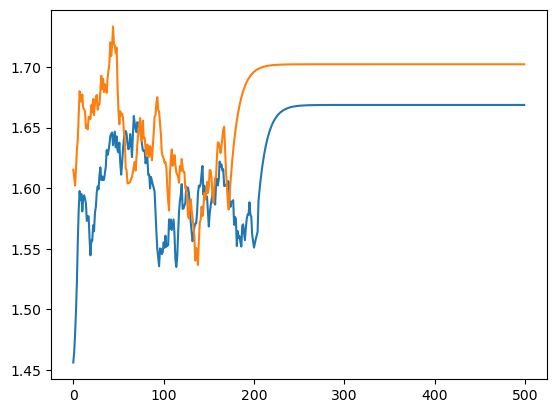

In [9]:
beg = 10
n = 2
step = 1
for i in range(beg, beg+n*step, step): 
    point_res = points_curves[i]
    plt.plot(smooth(point_res["force_z"], 0.9))

plt.show()

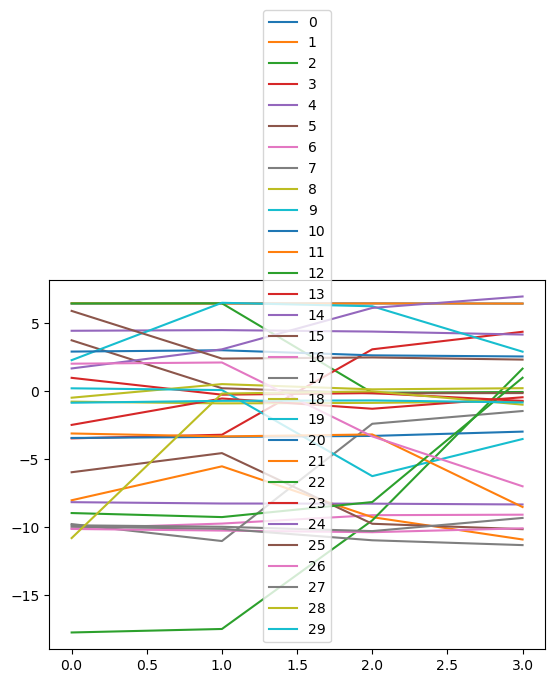

In [15]:
beg = 0
n = 30
step = 1
for i in range(beg, beg+n*step, step): 
    if i > len(points_curves):
        break
    point_res = points_curves[i]
    plt.plot(smooth([float(x) for x in point_res["tenso_signal"]], 0.01), label=i)

plt.legend()
plt.show()

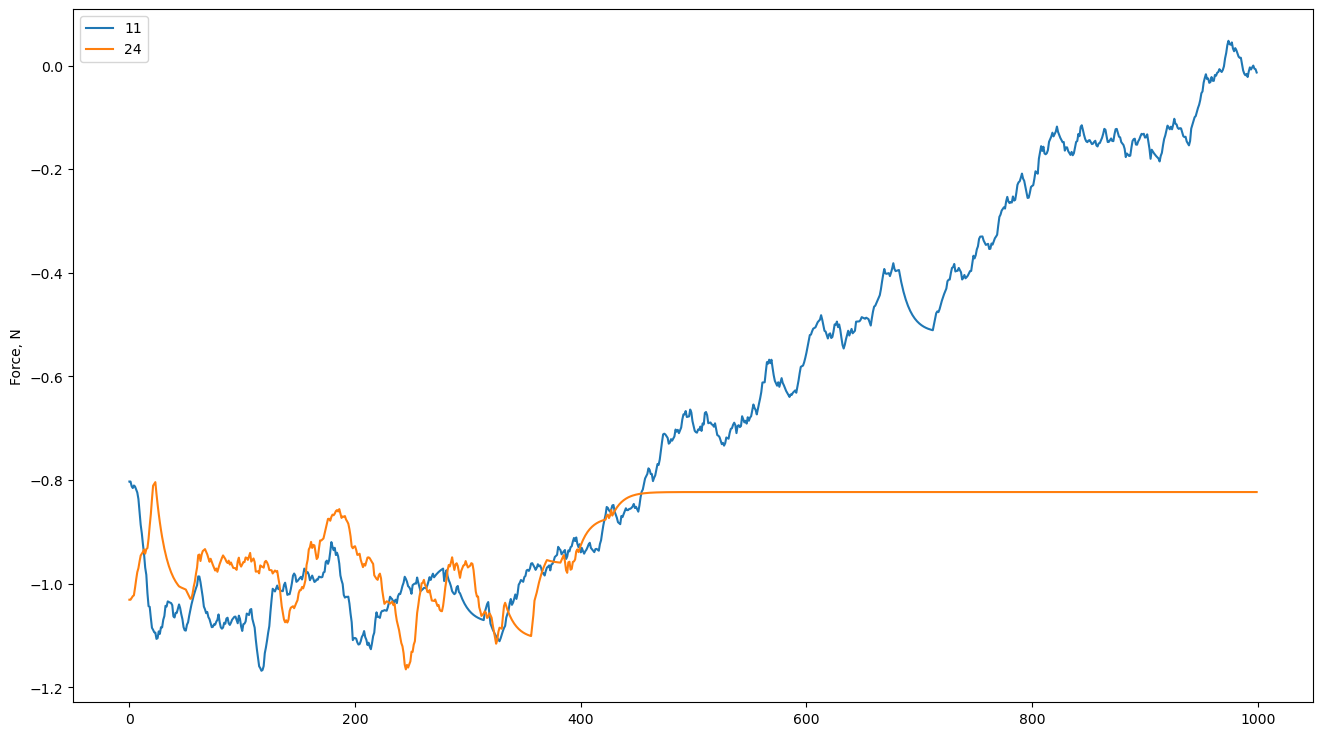

In [26]:
beg = 11
n = 2
step = 13
plt.figure(figsize=(16, 9))
plt.ylabel("Force, N")
for i in range(beg, beg+n*step, step): 
    if i > len(points_curves):
        break
    point_res = points_curves[i]
    data = point_res["force_z"]
    data = smooth(data, 0.9)
    plt.plot(data, label=i)

plt.legend()
# plt.savefig("forces.jpg", dpi=300)
plt.show()

### Sensor visualizing

In [49]:
def log_pars_func(point_res_dict):
    '''Returns max(absolute value) force'''
    return np.abs(point_res_dict['force_z']).max()
    
def sensor_plotting(id, log_parser_function, shape=[10, 4]):
    '''Plots 3d or heatmap visualization of spatial characteristics of sensor
    log_parser_function(dict_with_results_in_one_point) -> 1d value to visualize
    example:
    def log_pars_func(point_res_dict):
        """Returns max(absolute value) force"""
        return np.abs(point_res_dict['force_z']).max()
        
    '''
    points_curves = db.metrics.find_one({'_id': db.metrics.find_one({'run_id': id, 'name': 'point_results'})['_id']})['values']
    X = []
    Y = []
    Z = []
    for point_res in points_curves:
        xy = point_res['target_coordinate']
        X.append(xy[0])
        Y.append(xy[1])
        Z.append(log_parser_function(point_res))
    
    fig = plt.figure()
#     ax = fig.add_subplot(projection='3d')
# #     ax.plot_surface(np.array(X).reshape(-1, 1)), np.array(Y).reshape(1, -1), np.array(Z).reshape())
#     ax.scatter(np.array(X), np.array(Y), np.array(Z))
#     plt.hexbin(np.array(X), np.array(Y), np.array(Z), gridsize=(10, 2))
    plt.hist2d(np.array(X), np.array(Y), weights=np.array(Z), bins=shape)
    plt.show()

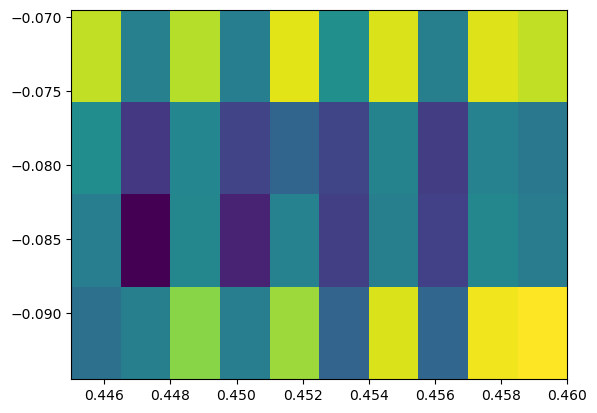

In [50]:
# %matplotlib notebook
%matplotlib inline
sensor_plotting(id, log_pars_func, shape=[10, 4])

<IPython.core.display.Javascript object>


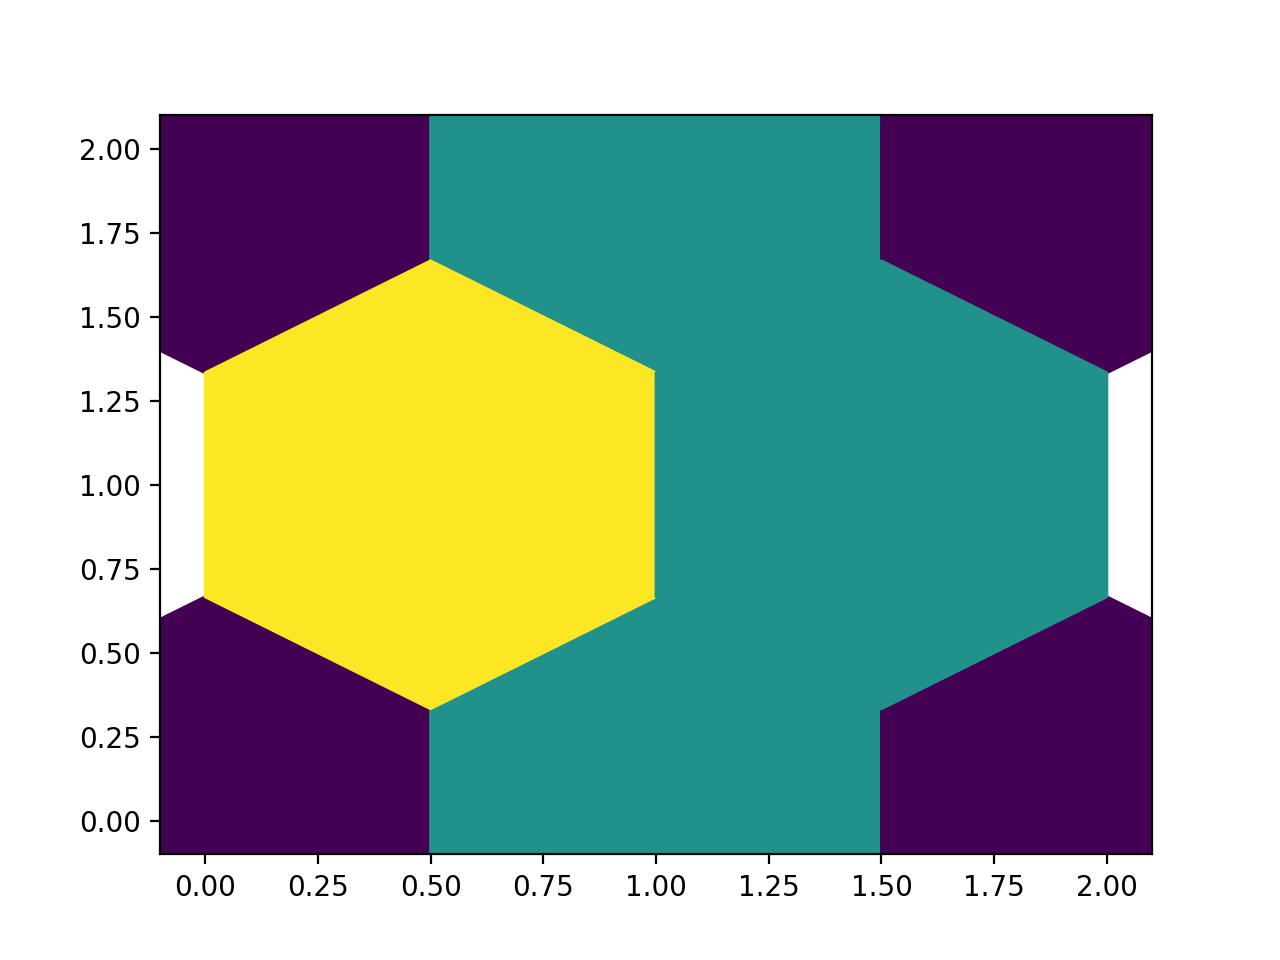

In [21]:
%matplotlib notebook
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.plot_surface(np.array([0, 1, 0, 1]).reshape((-1, 1)), np.array([0, 0, 1, 1]).reshape((-1, 1)), np.array([[3, 4, 6, 7]]))
plt.hexbin([0, 0, 0, 1, 1, 1, 2, 2, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], [0, 1, 0, 1, 3, 1, 0, 1, 0], gridsize=(2, 1))
# help(ax.plot_surface)

(array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 3., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <matplotlib.collections.QuadMesh at 0x7fdadea72ce0>)

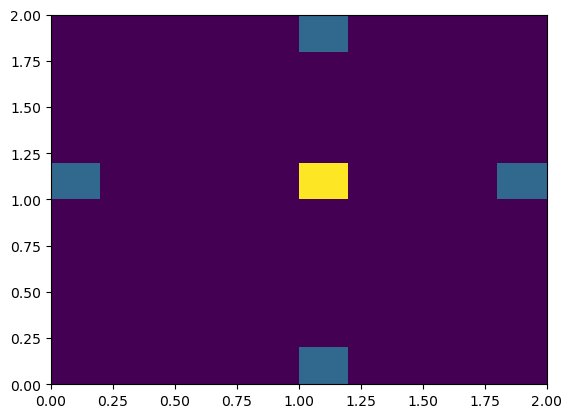

In [40]:
plt.hist2d([0, 0, 0, 1, 1, 1, 2, 2, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2], weights=[0, 1, 0, 1, 3, 1, 0, 1, 0]) # 

### 1d plot

In [ ]:
id = 516
points_curves = db.metrics.find_one({'_id': db.metrics.find_one({'run_id': id, 'name': 'point_results'})['_id']})['values']

In [9]:
points_curves[0].keys()

dict_keys(['target_coordinate', 'base_coordinate', 'force_z', 'vector_force', 'deformation', 'power', 'aim_force', 'tenso_signal', 'final_power'])

In [7]:
print(points_curves[0]['target_coordinate'], points_curves[1]['target_coordinate'])

[0.4498, 0.141] [0.4493, 0.141]


In [14]:
x = []
final_power = []

for point_res in points_curves:
    if point_res['target_coordinate'][1] != 0.141:
        break
    x.append(point_res['target_coordinate'][0])
    final_power.append(float(point_res['final_power'][-1]))
    
x, final_power

([0.4498,
  0.4493,
  0.4488,
  0.4483,
  0.4478,
  0.4473,
  0.4468,
  0.4463,
  0.4458,
  0.4453,
  0.4448,
  0.4443,
  0.4438,
  0.44329999999999997,
  0.44279999999999997,
  0.44229999999999997,
  0.44179999999999997,
  0.44129999999999997,
  0.44079999999999997,
  0.44029999999999997,
  0.43979999999999997,
  0.43929999999999997,
  0.43879999999999997,
  0.43829999999999997,
  0.43779999999999997,
  0.43729999999999997,
  0.43679999999999997],
 [0.0256625339,
  0.0240810551,
  0.027210366,
  0.0251802411,
  0.0241633076,
  0.0259578917,
  0.0290572867,
  0.0259504188,
  0.0302200299,
  0.0305565111,
  0.0225893091,
  0.00412141578,
  0.00514074601,
  0.000549981836,
  0.000848220196,
  0.0014536595,
  0.00774549507,
  0.00261820154,
  0.0238268264,
  0.0231762882,
  0.0239016004,
  0.0233744439,
  0.0243091192,
  0.0259205047,
  0.0225594006,
  0.0226341747,
  0.0243951119])

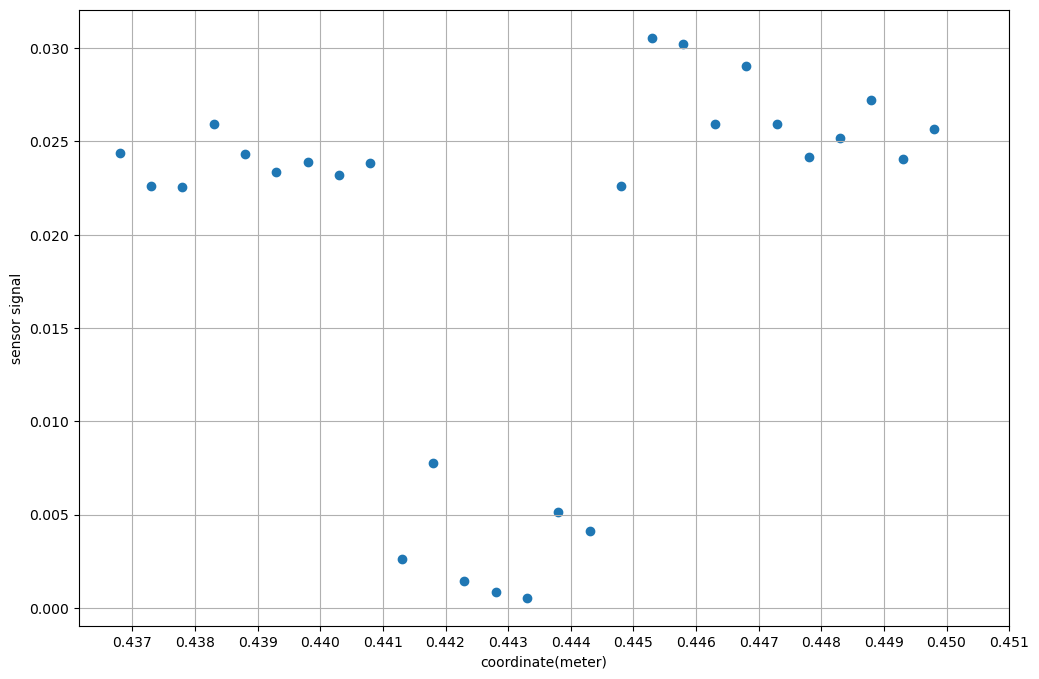

In [19]:
plt.figure(figsize=(12, 8))
plt.scatter(x, final_power)
plt.xticks(np.arange(0.437, 0.451, 0.001))
plt.xlabel("coordinate(meter)")
plt.ylabel("sensor signal")
plt.grid()

### next part